#LSTM + BiRNN

Done By : Sara Alsanajleh & Ghada AbuShaqra

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time


# Tokenization Function

In [ ]:
def tokenize(text):
    return text.lower().split()


# Vocabulary Builder

In [ ]:
class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]


# Dataset Class

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


# Padding Collate Function

In [ ]:
def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)


# Load GloVe Embeddings

In [ ]:
def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)


# LSTM Model Class

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_bilstm=True):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_bilstm = use_bilstm
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=use_bilstm)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_bilstm else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hn, _) = self.lstm(packed)
        if self.use_bilstm:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)


# BiRNN Model Class



In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3, use_birnn=True, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.use_birnn = use_birnn
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=use_birnn, dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if use_birnn else 1), 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.rnn(packed)
        if self.use_birnn:
            h_final = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            h_final = hn[-1]
        h_final = self.dropout(h_final)
        return self.fc(h_final)


# Evaluation Function

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4, output_dict=False)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm


# Accuracy Function

In [ ]:
def get_accuracy(model, dataloader, device):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)


# Training Function + Plots

In [ ]:
def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)

    train_losses = []
    train_accuracies = []
    dev_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        preds = []
        labels = []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)

        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        dev_accuracies.append(dev_acc)

        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='red')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(dev_accuracies, label='Dev Accuracy', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


# Confusion Matrix Plot

In [ ]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Main Function For LSTM Model

Epoch 1: Loss = 60.0654, Train Acc = 0.6665, Dev Acc = 0.7549
Epoch 2: Loss = 16.1426, Train Acc = 0.9547, Dev Acc = 0.7647
Epoch 3: Loss = 2.7776, Train Acc = 0.9914, Dev Acc = 0.6863
Epoch 4: Loss = 0.5511, Train Acc = 0.9988, Dev Acc = 0.7500
Epoch 5: Loss = 1.3445, Train Acc = 0.9976, Dev Acc = 0.7525
Epoch 6: Loss = 0.4518, Train Acc = 0.9982, Dev Acc = 0.7623
Epoch 7: Loss = 0.0611, Train Acc = 1.0000, Dev Acc = 0.7721
Epoch 8: Loss = 0.0141, Train Acc = 1.0000, Dev Acc = 0.7696
Epoch 9: Loss = 0.0128, Train Acc = 1.0000, Dev Acc = 0.7672
Epoch 10: Loss = 0.0067, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 11: Loss = 0.0052, Train Acc = 1.0000, Dev Acc = 0.7623
Epoch 12: Loss = 0.0045, Train Acc = 1.0000, Dev Acc = 0.7598
Epoch 13: Loss = 0.0035, Train Acc = 1.0000, Dev Acc = 0.7598
Epoch 14: Loss = 0.0042, Train Acc = 1.0000, Dev Acc = 0.7574
Epoch 15: Loss = 0.0027, Train Acc = 1.0000, Dev Acc = 0.7598


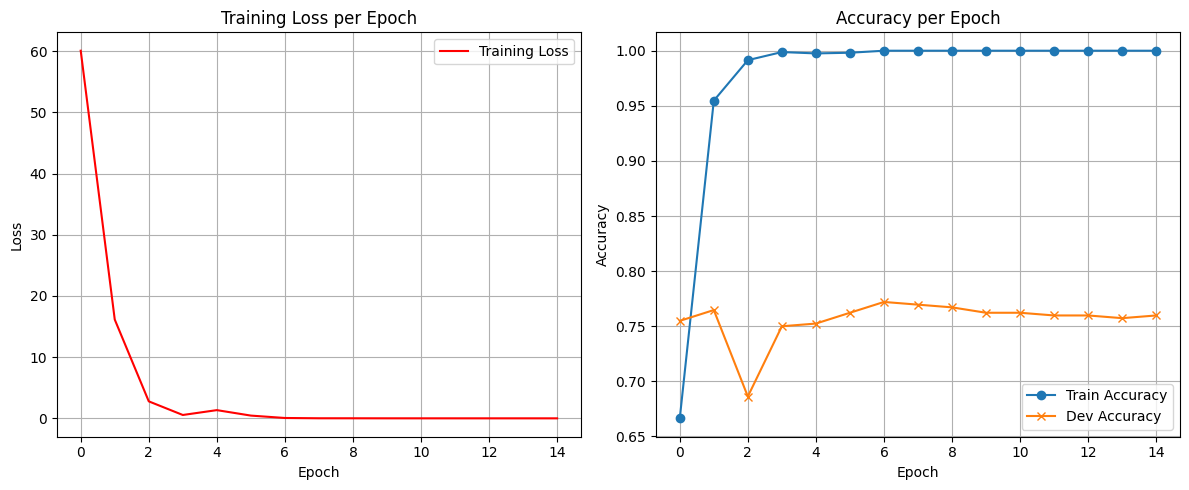


 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8442    0.6373    0.7263       204
           1     0.7087    0.8824    0.7860       204

    accuracy                         0.7598       408
   macro avg     0.7764    0.7598    0.7561       408
weighted avg     0.7764    0.7598    0.7561       408

Confusion Matrix:
 [[130  74]
 [ 24 180]]


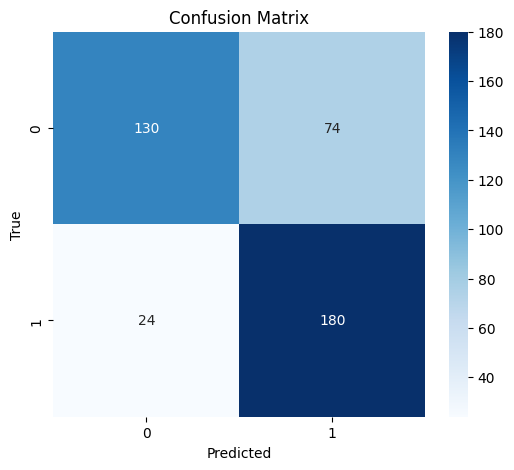


 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8339    0.6628    0.7386       341
           1     0.7202    0.8680    0.7872       341

    accuracy                         0.7654       682
   macro avg     0.7771    0.7654    0.7629       682
weighted avg     0.7771    0.7654    0.7629       682

Confusion Matrix:
 [[226 115]
 [ 45 296]]


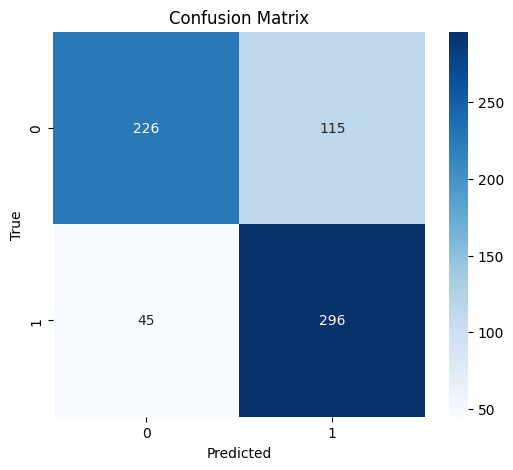

In [ ]:
def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 128
    batch_size = 16
    lr = 1e-2
    epochs = 15
    dropout = 0.3
    use_bilstm = False
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = LSTMModel(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                      embeddings=glove, dropout=dropout, use_bilstm=use_bilstm)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])




main()



# Main Function For BiRNN

Epoch 1: Loss = 36.9455, Train Acc = 0.5061, Dev Acc = 0.5980
Epoch 2: Loss = 34.2320, Train Acc = 0.6059, Dev Acc = 0.6887
Epoch 3: Loss = 30.0426, Train Acc = 0.7032, Dev Acc = 0.7206
Epoch 4: Loss = 25.6523, Train Acc = 0.7803, Dev Acc = 0.7598
Epoch 5: Loss = 20.9494, Train Acc = 0.8195, Dev Acc = 0.7255
Epoch 6: Loss = 16.0390, Train Acc = 0.8745, Dev Acc = 0.7770
Epoch 7: Loss = 11.9636, Train Acc = 0.9168, Dev Acc = 0.7941
Epoch 8: Loss = 8.8803, Train Acc = 0.9406, Dev Acc = 0.7451
Epoch 9: Loss = 5.8931, Train Acc = 0.9621, Dev Acc = 0.7402
Epoch 10: Loss = 4.7552, Train Acc = 0.9725, Dev Acc = 0.7083
Epoch 11: Loss = 3.2605, Train Acc = 0.9810, Dev Acc = 0.7328
Epoch 12: Loss = 2.0518, Train Acc = 0.9865, Dev Acc = 0.7157
Epoch 13: Loss = 1.0092, Train Acc = 0.9957, Dev Acc = 0.7377
Epoch 14: Loss = 1.3913, Train Acc = 0.9927, Dev Acc = 0.7623
Epoch 15: Loss = 1.5560, Train Acc = 0.9896, Dev Acc = 0.6765
Epoch 16: Loss = 1.3430, Train Acc = 0.9920, Dev Acc = 0.7377
Epoch 17: 

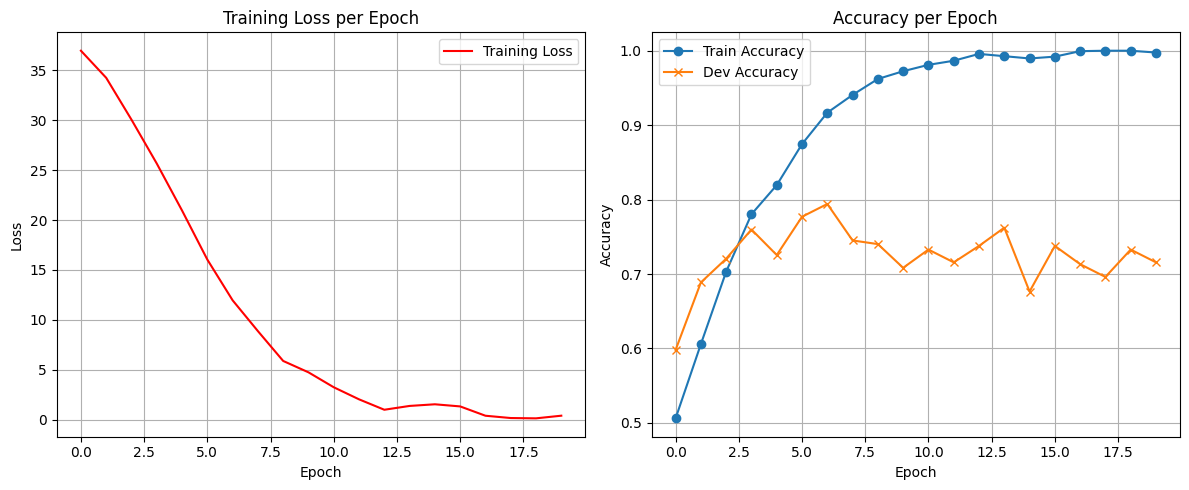


📈 Final Evaluation on Dev Set:
              precision    recall  f1-score   support

           0     0.8438    0.5294    0.6506       204
           1     0.6571    0.9020    0.7603       204

    accuracy                         0.7157       408
   macro avg     0.7504    0.7157    0.7055       408
weighted avg     0.7504    0.7157    0.7055       408

Confusion Matrix:
 [[108  96]
 [ 20 184]]


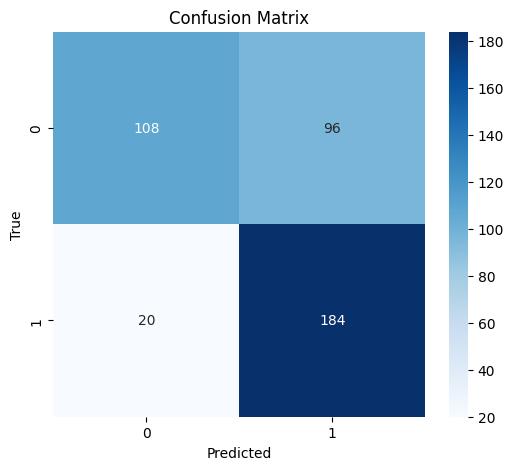


📈 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.8439    0.5073    0.6337       341
           1     0.6478    0.9062    0.7555       341

    accuracy                         0.7067       682
   macro avg     0.7459    0.7067    0.6946       682
weighted avg     0.7459    0.7067    0.6946       682

Confusion Matrix:
 [[173 168]
 [ 32 309]]


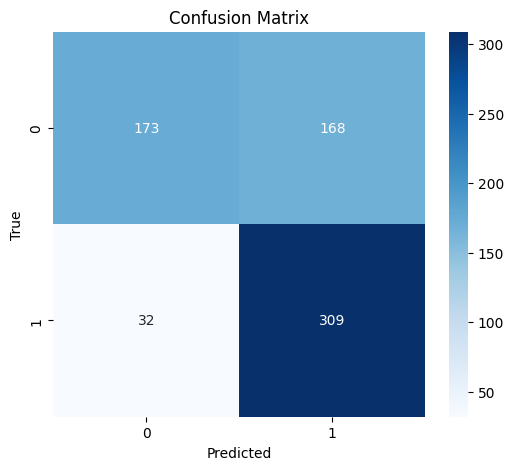

In [ ]:


def main():
    glove_path = "glove.6B.100d.txt"
    embedding_dim = 100
    hidden_dim = 64
    batch_size = 32
    lr = 5e-4
    epochs = 20
    dropout = 0.5
    use_birnn = True
    num_layers = 2
    optimizer_name = "Adam"

    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab
    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = RNNClassifier(len(vocab.word2idx), embedding_dim=embedding_dim, hidden_dim=hidden_dim,
                          embeddings=glove, dropout=dropout, use_birnn=use_birnn, num_layers=num_layers)

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=epochs)

    print("\n Final Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Final Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

main()


# BiLSTM + Attention


🚀 Training BiLSTM + Attention...
Epoch 1: Loss = 24.9952, Train Acc = 0.7552, Dev Acc = 0.8235
Epoch 2: Loss = 4.9708, Train Acc = 0.9676, Dev Acc = 0.8039
Epoch 3: Loss = 0.5165, Train Acc = 0.9963, Dev Acc = 0.8162
Epoch 4: Loss = 0.0838, Train Acc = 0.9994, Dev Acc = 0.8137
Epoch 5: Loss = 0.0323, Train Acc = 1.0000, Dev Acc = 0.8162
Epoch 6: Loss = 0.0065, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 7: Loss = 0.0044, Train Acc = 1.0000, Dev Acc = 0.8162
Epoch 8: Loss = 0.0032, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 9: Loss = 0.0025, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 10: Loss = 0.0020, Train Acc = 1.0000, Dev Acc = 0.8137
Epoch 11: Loss = 0.0017, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 12: Loss = 0.0014, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 13: Loss = 0.0012, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 14: Loss = 0.0010, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 15: Loss = 0.0009, Train Acc = 1.0000, Dev Acc = 0.8113
Epoch 16: Loss = 0.0008, Train Acc = 1.0000,

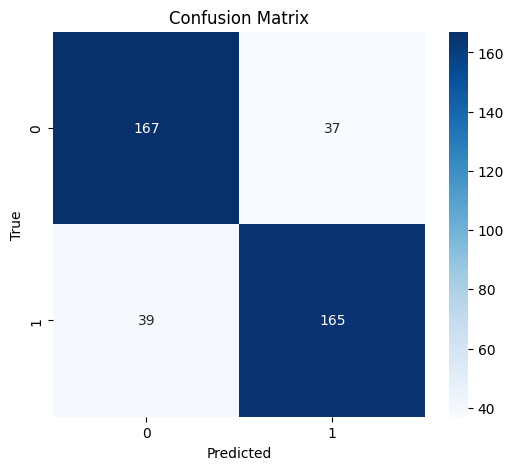


📈 Evaluation on Test Set:
              precision    recall  f1-score   support

           0     0.7799    0.8416    0.8096       341
           1     0.8280    0.7625    0.7939       341

    accuracy                         0.8021       682
   macro avg     0.8040    0.8021    0.8017       682
weighted avg     0.8040    0.8021    0.8017       682

Confusion Matrix:
 [[287  54]
 [ 81 260]]


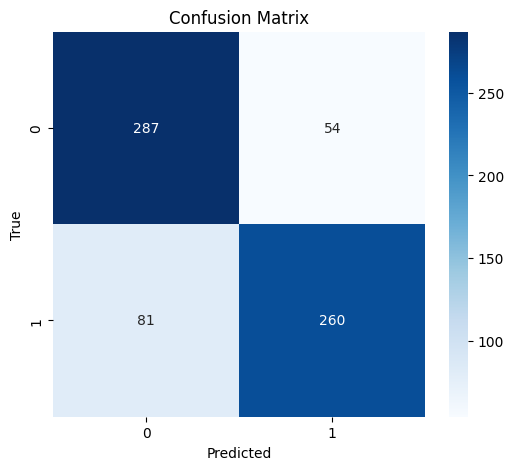


 Correct Example with Attention


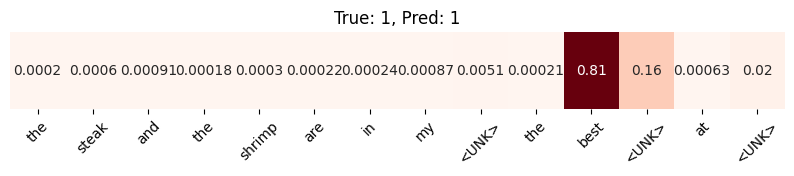


 Incorrect Example with Attention


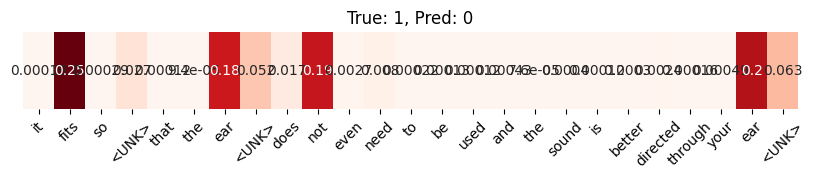

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def tokenize(text):
    return text.lower().split()

class Vocab:
    def __init__(self, sentences, min_freq=1):
        word_freq = {}
        for sent in sentences:
            for token in tokenize(sent):
                word_freq[token] = word_freq.get(token, 0) + 1
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = len(self.word2idx)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        return [self.word2idx.get(token, 1) for token in tokenize(sentence)]

class SentimentDataset(Dataset):
    def __init__(self, csv_path, vocab=None):
        df = pd.read_csv(csv_path)
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        if vocab is None:
            self.vocab = Vocab(self.sentences)
        else:
            self.vocab = vocab
        self.encoded = [self.vocab.encode(sent) for sent in self.sentences]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def pad_collate(batch):
    sentences, labels = zip(*batch)
    lengths = [len(x) for x in sentences]
    padded = torch.nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    return padded, torch.tensor(lengths), torch.tensor(labels)

def load_glove_embeddings(glove_path, word2idx, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    with open(glove_path, encoding="utf8") as f:
        for line in f:
            split = line.strip().split()
            word = split[0]
            if word in word2idx:
                vector = np.array(split[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states, mask):
        score = self.v(torch.tanh(self.W(hidden_states))).squeeze(-1)
        score = score.masked_fill(mask == 0, -1e9)
        weights = torch.softmax(score, dim=1)
        context = torch.bmm(weights.unsqueeze(1), hidden_states).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embeddings, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = AdditiveAttention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        unpacked, _ = self.lstm(packed)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
        mask = (x != 0).float()
        context, _ = self.attention(lstm_out, mask)
        context = self.dropout(context)
        return self.fc(context)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    report = classification_report(labels, preds, digits=4)
    cm = confusion_matrix(labels, preds)
    print(report)
    print("Confusion Matrix:\n", cm)
    return cm

def get_accuracy(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            output = model(x, lengths)
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())
    return accuracy_score(labels, preds)

def get_attention(model, dataloader, device):
    model.eval()
    all_weights, all_sentences, all_preds, all_labels = [], [], [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            embedded = model.embedding(x)
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            unpacked, _ = model.lstm(packed)
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(unpacked, batch_first=True)
            mask = (x != 0).float()
            context, weights = model.attention(lstm_out, mask)
            logits = model.fc(model.dropout(context))
            preds = torch.argmax(logits, dim=1)

            all_weights.extend(weights.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())
            all_sentences.extend(x.cpu().tolist())

    return all_sentences, all_weights, all_preds, all_labels

def visualize_attention(example_idx, sentences, weights, labels, preds, vocab):
    tokens = [vocab.idx2word.get(idx, "<UNK>") for idx in sentences[example_idx] if idx != 0]
    attention = weights[example_idx][:len(tokens)]

    plt.figure(figsize=(10, 1))
    sns.heatmap([attention], xticklabels=tokens, cmap="Reds", annot=True, cbar=False)
    plt.title(f"True: {labels[example_idx]}, Pred: {preds[example_idx]}")
    plt.yticks([])
    plt.xticks(rotation=45)
    plt.show()

def train(model, train_loader, dev_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss, preds, labels = 0, [], []

        for x, lengths, y in train_loader:
            x, lengths, y = x.to(device), lengths.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x, lengths)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(y.cpu().tolist())

        train_acc = accuracy_score(labels, preds)
        dev_acc = get_accuracy(model, dev_loader, device)
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    glove_path = "glove.6B.300d.txt"
    embedding_dim = 300
    hidden_dim = 64
    batch_size = 32
    lr = 1e-2
    epochs = 32
    dropout = 0






    train_data = SentimentDataset("sentiment_train.csv")
    dev_data = SentimentDataset("sentiment_dev.csv", vocab=train_data.vocab)
    test_data = SentimentDataset("sentiment_test.csv", vocab=train_data.vocab)
    vocab = train_data.vocab

    glove = load_glove_embeddings(glove_path, vocab.word2idx, embedding_dim=embedding_dim)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

    model = BiLSTMWithAttention(len(vocab.word2idx), embedding_dim, hidden_dim, glove, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("\n Training BiLSTM + Attention...")
    train(model, train_loader, dev_loader, optimizer, criterion, device, epochs)

    print("\n Evaluation on Dev Set:")
    dev_cm = evaluate(model, dev_loader, device)
    plot_confusion_matrix(dev_cm, ["0", "1"])

    print("\n Evaluation on Test Set:")
    test_cm = evaluate(model, test_loader, device)
    plot_confusion_matrix(test_cm, ["0", "1"])

    sents, attns, preds, labels = get_attention(model, test_loader, device)
    for i in range(len(sents)):
        if preds[i] == labels[i]:
            print("\n Correct Example with Attention")
            visualize_attention(i, sents, attns, labels, preds, vocab)
            break
    for i in range(len(sents)):
        if preds[i] != labels[i]:
            print("\n Incorrect Example with Attention")
            visualize_attention(i, sents, attns, labels, preds, vocab)
            break

main()